# Getting Started with the Metrics API

This notebook serves as a tutorial for the Metrics endpoint in the Signal AI API.

Full technical documentation of the Metrics endpoint is available here
https://api.signal-ai.com/docs#tag/Content-Metrics


## Metrics API Overview

The Metrics API provides at-a-glance aggregated metrics over all news & regulatory content available in our platform. It supports analysing our content accross multiple dimensions, and enables users to monitor, visualise and understand information such as the following:
- Changes in sentiment for an entity over time
- Sentiment for an entity in relation to a set of key topics
- News coverage and sentiment around an entity in different locations
- Difference in coverage and sentiment between entities over time and in relation to different topics

## 0. Setting things up!

### 0.1 Pre-requisites

Please make sure that you have familiarised yourself with the Signal AI API using the [Getting Started notebook](getting_started.ipynb)

In particular you would need to be able to use the following endpoints:

- Authentication: to be able to access the API
- Discovery: to be able to search for entities and topics of interest


Note: run `pip install -r requirements.txt` to install the dependencies for this notebook

In [1]:
import requests
import os
import pandas as pd
import numpy as np
import json
import datetime
from pandas import json_normalize

### 0.2 Check if authentication works!

You will need a client_id and client_secret to gain access to the API. The code below will assume they have been set and the environment variables `SIGNAL_API_CLIENT_ID` and `SIGNAL_API_CLIENT_SECRET` respectively.

Using your credentials you can request a temporary access token from the API using the url: https://api.signal-ai.com/auth/token


In [2]:
def authenticate(client_id, client_secret, url = "https://api.signal-ai.com"):
    """ obtain a temporary access token using user credentials """
    token_url = f'{url}/auth/token'
    payload = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }
    response = requests.post(token_url, data=payload)
    return response.json().get("access_token")

In [3]:
TEMP_ACCESS_TOKEN = authenticate(os.environ['SIGNAL_API_CLIENT_ID'], os.environ['SIGNAL_API_CLIENT_SECRET'])
if TEMP_ACCESS_TOKEN:
    print('Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step')
else:
    print('Error: Perhaps the credentials are incorrect?')

Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step


## Using the Metrics API

Before we start, let us define a request function that we can re-use across different example use cases.

In [4]:
def request(json=None):
    """ Make requests using a tempory access token """
    response = requests.post(
        'https://api.signal-ai.com/metrics',
        json=json,
        headers={
            "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
            "Content-Type": "application/json"
        },
    )
    return response


Following are some examples of the questions that can be answered using Metrics API.

**Use case question**:

- How has the sentiment around my organisation been changing over time?

Note that you would need to have the ID of the entity as an input. For that please consult the [Getting Started notebook](getting_started.ipynb) to search for entities and obtain the ID of your chosen entity.




**Example**: Week-on-week sentiment towards Tesla, Inc. in the last 6 months

In [5]:
todays = datetime.datetime.today().strftime('%Y-%m-%d')
six_months_ago = (datetime.datetime.today() - datetime.timedelta(days=180)).strftime('%Y-%m-%d')

In [6]:
entity_id = "11cab8df-4be1-470f-8f49-8f7f0863ec95" ##  ID for Tesla, Inc.

query = {
    # First we define the data to be included in the aggregation. 
    # This part of the query has got the same format as the query in the `Search` endpoint
    "where": {
        "published-at": {
            "gte": six_months_ago,
            "lte": todays
        },
        "entities": {
            "id": { "eq": entity_id }
        }
    },
    # Then we define how the data should be aggregated. 
    # Note the `entity > include` option is used to specify the ID(s) of the entities we want the data to be grouped by.
    "aggregations": {
        "group-by": [
            "published-at",
            "entity",
            "entity.sentiment"
            
        ],
        "options": {
            "published-at": { "interval": "week" },
            "entity": { "include": [ entity_id ] }
        },
        "metrics": ["document-count"]
    }
}

# Return the response in JSON format
results = request(json=query).json()

You can see the structure of a typical Metrics API response:

In [7]:
json_normalize(results, 'aggregations').head()

,published-at,entity.sentiment,document-count,entity.id,entity.type,entity.name
0,2021-05-24,negative,2516,11cab8df-4be1-470f-8f49-8f7f0863ec95,organisation,"Tesla, Inc."
1,2021-05-24,neutral,6064,11cab8df-4be1-470f-8f49-8f7f0863ec95,organisation,"Tesla, Inc."
2,2021-05-24,positive,5731,11cab8df-4be1-470f-8f49-8f7f0863ec95,organisation,"Tesla, Inc."
3,2021-05-31,negative,12079,11cab8df-4be1-470f-8f49-8f7f0863ec95,organisation,"Tesla, Inc."
4,2021-05-31,neutral,19399,11cab8df-4be1-470f-8f49-8f7f0863ec95,organisation,"Tesla, Inc."


We can fitler and reshape our dataframe for better readability.

In [8]:
df = json_normalize(results, 'aggregations')
df = df.reindex(columns=['published-at', 'entity.sentiment', 'document-count'])
stacked_df = df.groupby(['published-at', 'entity.sentiment']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
stacked_df.head(10)

entity.sentiment,negative,neutral,positive
published-at,,,
2021-05-24,2516,6064,5731
2021-05-31,12079,19399,19330
2021-06-07,6403,21276,22662
2021-06-14,6810,18193,20373
2021-06-21,5928,17258,20547
2021-06-28,5908,16843,21667
2021-07-05,5769,16636,19833
2021-07-12,8014,16899,19471
2021-07-19,7800,22057,24534


We can also plot the results to observe the temporal changes in sentiment

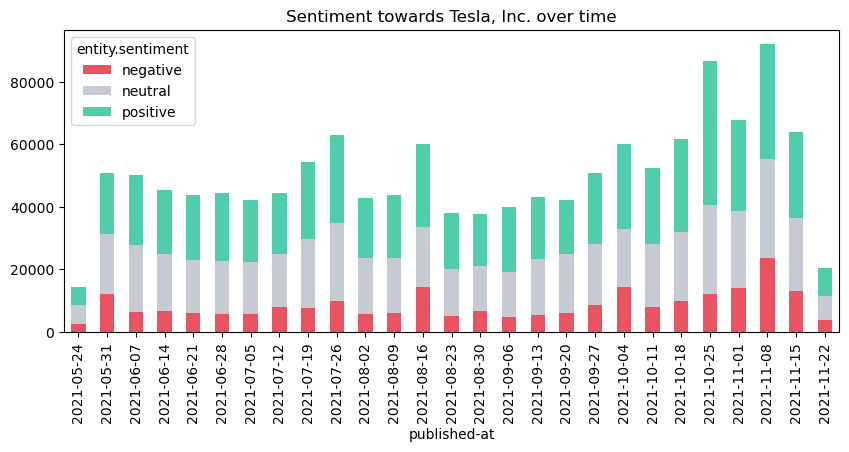

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[10,4], dpi=100, facecolor='w')
ax1 = plt.subplot(111)
stacked_df.plot.bar(
    stacked=True, 
    ax=ax1,
    color=['#EA5462', '#C5CAD3' ,'#50CEAC']
)
_ = ax1.set_title('Sentiment towards Tesla, Inc. over time')

### 2. Sentiment for an entity in relation to a set of key topics

**Use case question**:

- How is the overall sentiment trending towards organisations in my portfolio in relation to a set of key topics? 

**Example**: Sentiment trends around 7 car manufacturers in the last month compared to the month before in relation to a set of 6 strategic topics

In [10]:
topic_ids = [
    "fc31abf2-7b11-4ed5-a7d2-35266057c0dd", 
    "c3e9ec2f-e225-4955-9dbf-5480ce3d30fe", 
    "a301b00d-f4ef-49fb-9224-f52386d4955e", 
    "fdcb69a5-8aa6-4067-a29b-f064321e1d7d", 
    "4249987d-5b02-4e51-9c44-019dd8e39742", 
    "8de14dc1-6a93-4d1f-b755-a8d7aa570187"
    ] ## IDs of the following topics: Innovation, Patents & Invention, Corporate Culture, Corporate Governance, Corporate Responsibility, Sustainability

entity_ids = [
    "d6341968-83df-441c-a869-fa7ae9c22c73", 
    "d7f0268d-1322-32b2-83d9-bb6fa9922506", 
    "a9cf01c5-751f-4fe5-a529-12e0d297cb63", 
    "c4ad0758-f3ee-4002-84aa-10849a153d75", 
    "06608104-0136-4371-ad04-be40fcc306a4", 
    "11cab8df-4be1-470f-8f49-8f7f0863ec95", 
    "946b44a8-b767-40ca-8093-e90d6af2a9d4"
] ##  IDs of the following car manufacturers: Toyota, Volkswagen, General Motors, Honda, BMW, Tesla, Ford



# idnetify the start and end date of the query
last_day_prev_month = datetime.datetime.today().replace(day=1)- datetime.timedelta(days=1) # if today is 2021-11-19, this will give us 2021-10-31
last_day_prev_month_str = last_day_prev_month.strftime('%Y-%m-%d')
first_day_prev_month = last_day_prev_month.replace(day=1)

first_day_2_months_ago = (last_day_prev_month.replace(day=1) - datetime.timedelta(days=1)).replace(day=1) # if today is 2021-11-19, this will give us 2021-09-01
first_day_2_months_ago_str = first_day_2_months_ago.strftime('%Y-%m-%d') 

query = {
    "where": {
        "published-at": {
            "gte": first_day_2_months_ago_str, 
            "lte": last_day_prev_month_str
        },
        "topics": {
            "id": { "any": topic_ids }
        },
        "entities": {
            "id": { "any": entity_ids }
        }
    },
    "aggregations": {
        # Group by topic, entity and sentiment
        "group-by": [
            "published-at",
            "topic",
            "entity",
            "entity.sentiment"
        ],
        "options": {
            "published-at": { "interval": "month" },
            "topic": { "include": topic_ids },
            "entity": { "include": entity_ids }
        },
        "metrics": ["document-count"]
    }
}

car_manufacturers_result = request(json=query).json()

You can see the structure of the response

In [11]:
json_normalize(car_manufacturers_result, 'aggregations').head()

,published-at,entity.sentiment,document-count,topic.id,topic.name,entity.id,entity.type,entity.name
0,2021-09-01,negative,385,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,d6341968-83df-441c-a869-fa7ae9c22c73,organisation,Toyota
1,2021-09-01,neutral,5359,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,d6341968-83df-441c-a869-fa7ae9c22c73,organisation,Toyota
2,2021-09-01,positive,22522,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,d6341968-83df-441c-a869-fa7ae9c22c73,organisation,Toyota
3,2021-09-01,negative,256,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,c4ad0758-f3ee-4002-84aa-10849a153d75,organisation,Honda
4,2021-09-01,neutral,4266,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,c4ad0758-f3ee-4002-84aa-10849a153d75,organisation,Honda


In [12]:
df = json_normalize(car_manufacturers_result, 'aggregations')
df = df.reindex(columns=[ 'published-at', 'entity.name', 'topic.name', 'entity.sentiment', 'document-count'])
df.style.set_caption('Sentiment breakdown by car manufacturer and topic')
df.head(10)

,published-at,entity.name,topic.name,entity.sentiment,document-count
0,2021-09-01,Toyota,Innovation,negative,385
1,2021-09-01,Toyota,Innovation,neutral,5359
2,2021-09-01,Toyota,Innovation,positive,22522
3,2021-09-01,Honda,Innovation,negative,256
4,2021-09-01,Honda,Innovation,neutral,4266
5,2021-09-01,Honda,Innovation,positive,13678
6,2021-09-01,Ford Motor Company,Innovation,negative,447
7,2021-09-01,Ford Motor Company,Innovation,neutral,5622
8,2021-09-01,Ford Motor Company,Innovation,positive,16779
9,2021-09-01,"Tesla, Inc.",Innovation,negative,1477


We will now compute a sentiment polarity matrix with two dimensions, entities and topics, for each month. ( sentiment polarity is the total number of positive articles minus the total number of negative articles). 

Then, we compute the matrix that shows the delta between the two


In [14]:
def transform_data(some_df):    
    stacked_df = some_df.groupby(['entity.name', 'topic.name', 'entity.sentiment']).sum().unstack()
    stacked_df.columns = stacked_df.columns.droplevel(0)

    reseted_df = stacked_df.reset_index()
    
    return reseted_df.pivot_table(values='negative', index=reseted_df['entity.name'], columns='topic.name')

month_data_frames = {
    group: transform_data(date_df.drop(columns=["published-at"])) for group, date_df in df.groupby('published-at')
}

first_df = month_data_frames[first_day_2_months_ago_str]
second_df = month_data_frames[first_day_prev_month.strftime('%Y-%m-%d')]
trend_df= second_df.sub(first_df)
trend_df

topic.name,Corporate Governance,Corporate Responsibility,Corporate culture,Innovation,Patents & Inventions,Sustainability
entity.name,,,,,,
BMW,3,-98,-1,-14,-46,103
Ford Motor Company,572,253,-149,13,348,441
General Motors,457,-73,-134,-133,362,601
Honda,9,-1,18,-53,-11,130
"Tesla, Inc.",1869,92,2913,-352,-309,3418
Toyota,145,8,-18,452,610,397
Volkswagen,65,-37,14,-110,-14,682


Now we visualise this matrix

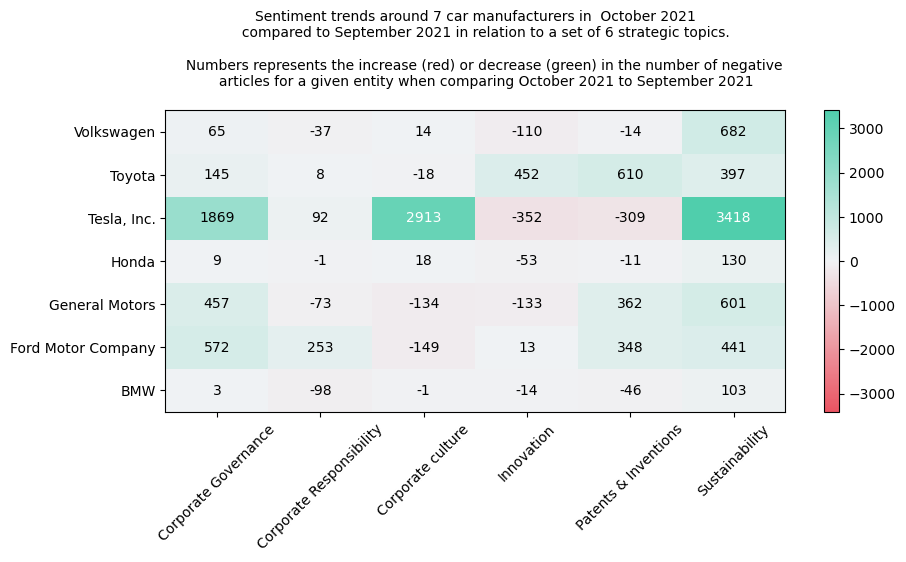

In [19]:
import matplotlib.colors as clr


## helper function to show numeric values in the matplotlib pcolor heatmap
def show_values(pc, fmt="%d", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

# gradient color map from red to grey to green
cmap = clr.LinearSegmentedColormap.from_list('', ['#EA5462','#f0f2f4', '#50CEAC'], N=256)
        
        
fig = plt.figure(figsize=[10,4], dpi=100, facecolor='w')
ax1 = plt.subplot(111)

# min and max values for the colors
min_value = trend_df.min().min()
max_value = trend_df.max().max()
abs_max=max(abs(min_value), abs(max_value))

pc = ax1.pcolor(trend_df, vmin=-1*abs_max, vmax=abs_max, cmap=cmap)
show_values(pc)
plt.colorbar(pc)

ax1.set_xticks(np.arange(trend_df.shape[1]) + 0.5, minor=False)
ax1.set_yticks(np.arange(trend_df.shape[0]) + 0.5, minor=False)

ax1.set_xticklabels(list(trend_df.columns), rotation=45)
ax1.set_yticklabels(list(trend_df.index))


_ = ax1.set_title(
    '''Sentiment trends around 7 car manufacturers in  {0}
     compared to {1} in relation to a set of 6 strategic topics.
     
     Numbers represents the increase (red) or decrease (green) in the number of negative 
     articles for a given entity when comparing {0} to {1}
     '''.format(
        last_day_prev_month.strftime('%B %Y'),
        first_day_2_months_ago.strftime('%B %Y')
    )
)

ax1.title.set_fontsize(10)


### 3. News coverage and sentiment around an entity in different locations

**Use case question**:

- How do news coverage and sentiment around my agency’s clients vary across different countries?

**Example**: Coverage and sentiment around Uber in the last month and in 5 different countries

In [54]:
entity_id = "0c20f04a-94ef-467c-921d-f89f8895c41a" ##  ID for Uber
countries = [
    "United States", 
    "United Kingdom", 
    "Germany", 
    "France", 
    "Spain"
    ]

# idnetify the start and end date of the query
last_day_prev_month = datetime.datetime.today().replace(day=1)- datetime.timedelta(days=1) # if today is 2021-11-19, this will give us 2021-10-31
last_day_prev_month_str = last_day_prev_month.strftime('%Y-%m-%d')
first_day_prev_month = last_day_prev_month.replace(day=1)
first_day_prev_month_str = first_day_prev_month.strftime('%Y-%m-%d')



query = {
    "where": {
        "published-at": {
            "gte": "2021-02-01",
            "lte": last_day_prev_month_str
        },
        # Here we can narrow our search by selecting only the documents where Uber is mentioned
        "entities": {
            "id": {
                "eq": entity_id
            }
        }
    },
    "aggregations": {
        "group-by": [
            "source.country",
            "entity",
            "entity.sentiment"
        ],
        "options": {
            "source.country": { "include": countries },
            "entity": { "include": [entity_id] }
        },
        "metrics": ["document-count"]
    }
}

uber_result = request(json=query).json()

Transform the results into a dataframe for easier processing

In [55]:
json_normalize(uber_result, 'aggregations').head()

,source.country,entity.sentiment,document-count,entity.id,entity.type,entity.name
0,United States,negative,51007,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
1,United States,neutral,167048,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
2,United States,positive,113767,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
3,United Kingdom,negative,6836,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
4,United Kingdom,neutral,18132,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)


In [56]:
df = json_normalize(uber_result, 'aggregations')
df = df.reindex(columns=['source.country', 'entity.sentiment', 'document-count'])

df.style.set_caption('Sentiment towards Uber in February 2021')


stacked_df = df.groupby(['source.country', 'entity.sentiment']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
stacked_df.head(10)

entity.sentiment,negative,neutral,positive
source.country,,,
France,2099,7237,6370
Germany,2882,8992,6991
Spain,813,4558,2847
United Kingdom,6836,18132,14838
United States,51007,167048,113767


Now visualise

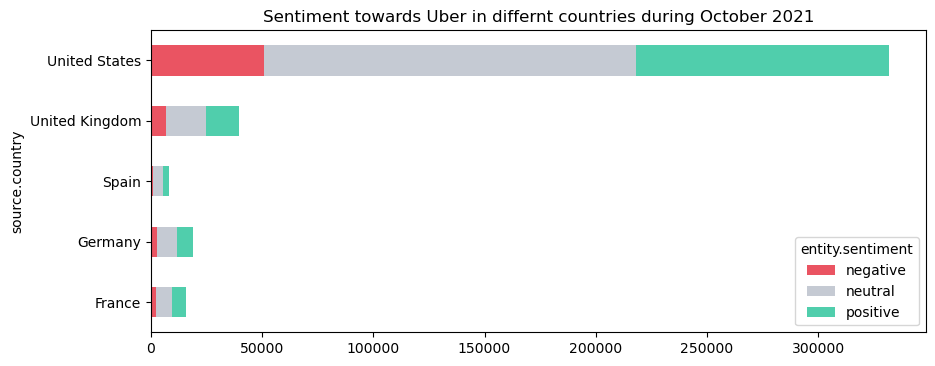

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[10,4], dpi=100, facecolor='w')
ax1 = plt.subplot(111)
stacked_df.plot.barh(
    stacked=True,
    ax=ax1,
    color=['#EA5462', '#C5CAD3' ,'#50CEAC']
)
_ = ax1.set_title('Sentiment towards Uber in differnt countries during {}'.format(first_day_prev_month.strftime('%B %Y')))

### 4. Difference in coverage and sentiment between entities over time and in relation to different topics

**Use case question**:

- How do different organisations that I monitor compare with respect to coverage and sentiment in relation to key topics?

**Example**: Coverage and sentiment around 4 competitors in the mining industry in the last 6 months and in relation to 4 ESG topics

In [58]:
topic_ids = [
    "22297881-a936-4b51-a880-a7152c8ecc68",
    "4249987d-5b02-4e51-9c44-019dd8e39742",
    "8de14dc1-6a93-4d1f-b755-a8d7aa570187",
    "fc31abf2-7b11-4ed5-a7d2-35266057c0dd"
    ] ## IDs of the following topics: Environmental Cleanup, Corporate Responsibility,  Sustainability, Innovation

entity_ids = [
   "72800724-103f-4370-942a-0e715b58ee4a",
   "3d885924-a230-4fac-b17a-d5a1c1151cdf",
   "98eeff9c-6a9a-4d62-801d-eb94b240dd42",
   "592930e0-70fe-45f7-8a1e-ec504158dbf9"
    ] ##  IDs of the following mining companies: Rio Tinto, BHP, Glencore & Anglo American

query = {
    "where": {
        "published-at": {
            "gte": six_months_ago,
            "lte": todays
        },
        "topics": {
            "id": { "any": topic_ids }
        },
        "entities": {
            "id": { "any": entity_ids }
        }
    },
    "aggregations": {
        "group-by": [
            "published-at",
            "topic",
            "entity",
        ],
        "options": {
            "published-at": { "interval": "week" },
            "topic": { "include": topic_ids },
            "entity": { "include": entity_ids }
        },
        "metrics": ["document-count"]
    }
}

mining_companies_result = request(json=query).json()

In [59]:
json_normalize(mining_companies_result, 'aggregations').head()

,published-at,document-count,topic.id,topic.name,entity.id,entity.type,entity.name
0,2021-05-17,13,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,72800724-103f-4370-942a-0e715b58ee4a,organisation,Rio Tinto Group
1,2021-05-17,7,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,98eeff9c-6a9a-4d62-801d-eb94b240dd42,organisation,Glencore
2,2021-05-17,6,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,592930e0-70fe-45f7-8a1e-ec504158dbf9,organisation,Anglo American plc
3,2021-05-17,6,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,3d885924-a230-4fac-b17a-d5a1c1151cdf,organisation,BHP
4,2021-05-17,10,8de14dc1-6a93-4d1f-b755-a8d7aa570187,Sustainability,72800724-103f-4370-942a-0e715b58ee4a,organisation,Rio Tinto Group


In [60]:
df = json_normalize(mining_companies_result, 'aggregations')
df['published-at'] = pd.to_datetime(df['published-at'])

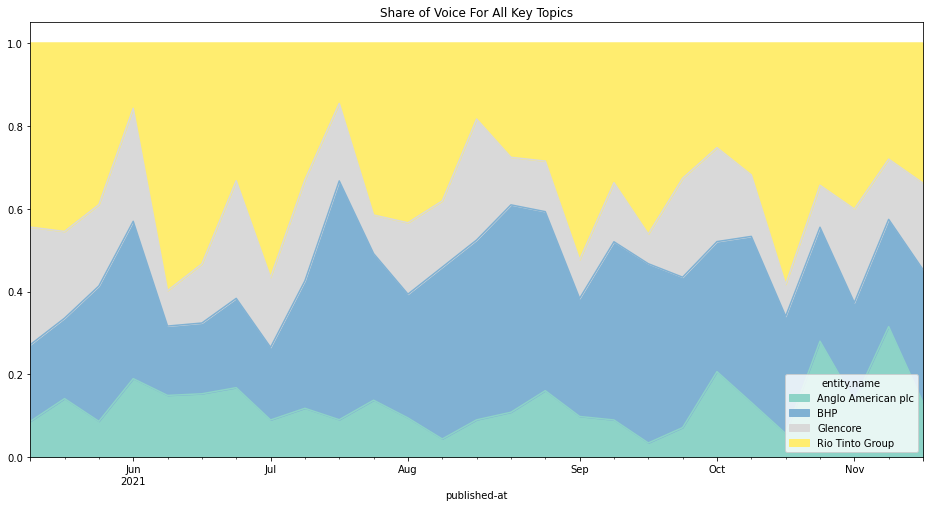

In [61]:
stacked_df = df.groupby(['published-at', 'entity.name']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
_ = stacked_df.divide(stacked_df.sum(axis=1), axis=0).plot.area(
    title='Share of Voice For All Key Topics', 
    figsize=[16,8],
    colormap="Set3"
)

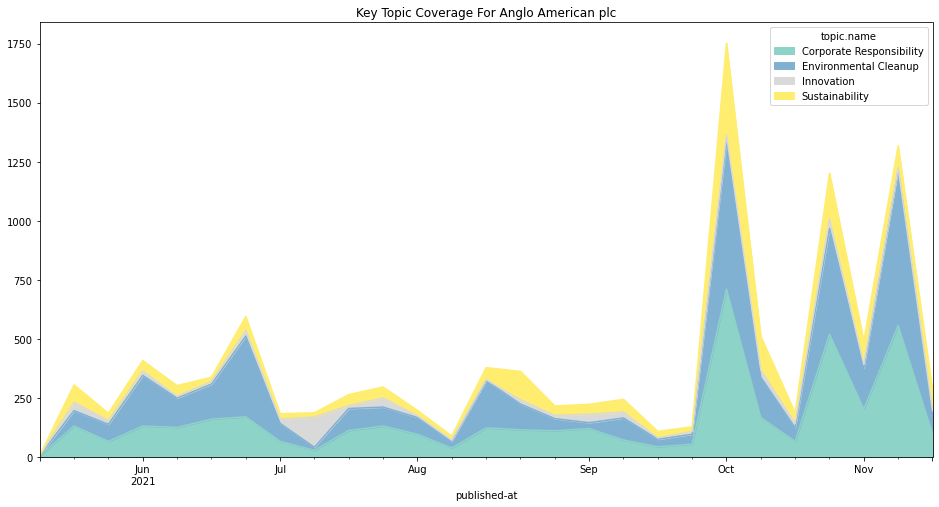

In [62]:
stacked_df = df[df['entity.name'] == 'Anglo American plc'].groupby(['published-at', 'topic.name']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
_ = stacked_df.plot.area(
    title='Key Topic Coverage For Anglo American plc',
    figsize=[16,8],
    colormap="Set3",
)